## Houmath's excellent notebook + median filtering

In [2]:
from __future__ import division
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize']=(20.0,10.0)
inline_rc = dict(mpl.rcParams)

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from scipy.signal import medfilt

from pandas.tools.plotting import scatter_matrix

import matplotlib.colors as colors

import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from classification_utilities import display_cm, display_adj_cm
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import validation_curve
from sklearn.datasets import load_svmlight_files

from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack
from sklearn import metrics
from scipy.spatial.distance import correlation
from scipy.signal import medfilt, gaussian
seed = 123
np.random.seed(seed)

In [3]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [4]:
# Load data from file
data = pd.read_csv('facies_vectors.csv')

In [5]:
X = data[feature_names].values
y = data['Facies'].values

In [6]:
well = data['Well Name'].values
depth = data['Depth'].values

In [7]:
# Define function for plotting feature statistics
def plot_feature_stats(X, y, feature_names, facies_colors, facies_names):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_names):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_names):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_names)))

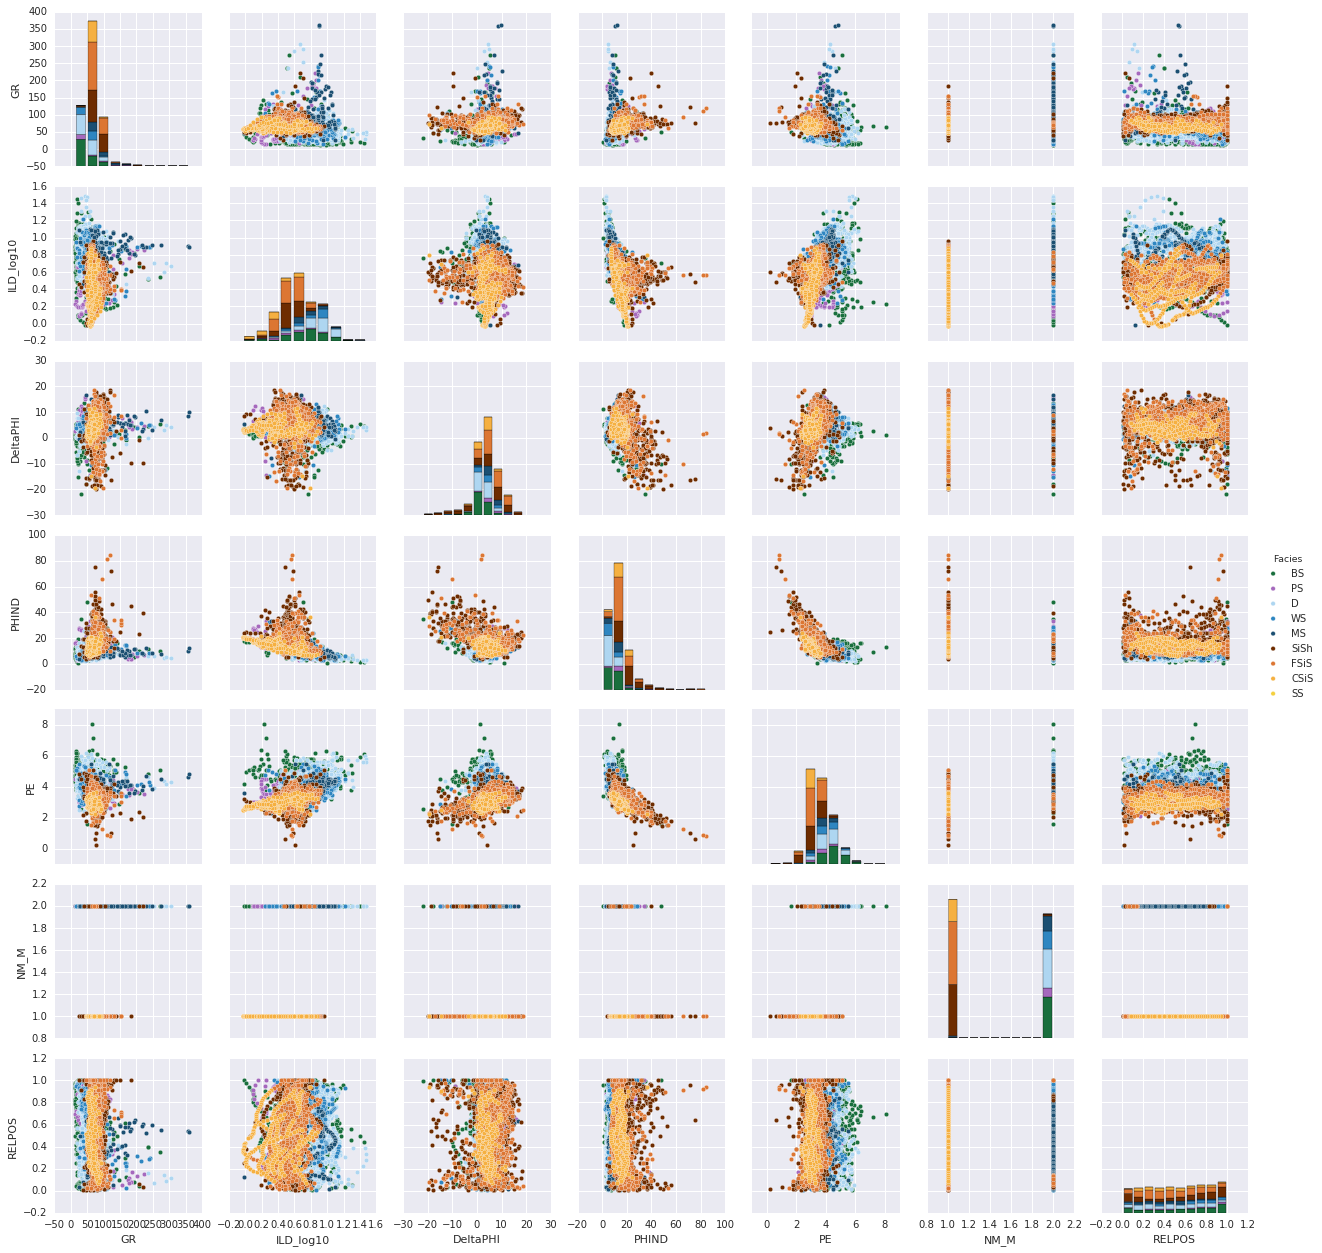

In [8]:
# Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_names)
mpl.rcParams.update(inline_rc)

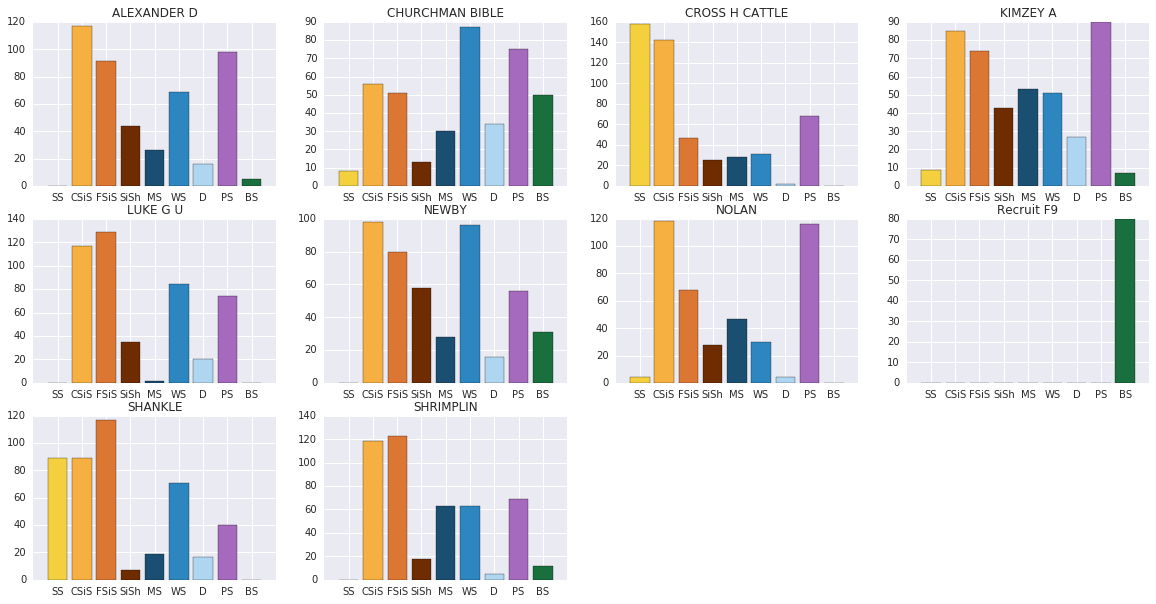

In [9]:
# Facies per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(y[well == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

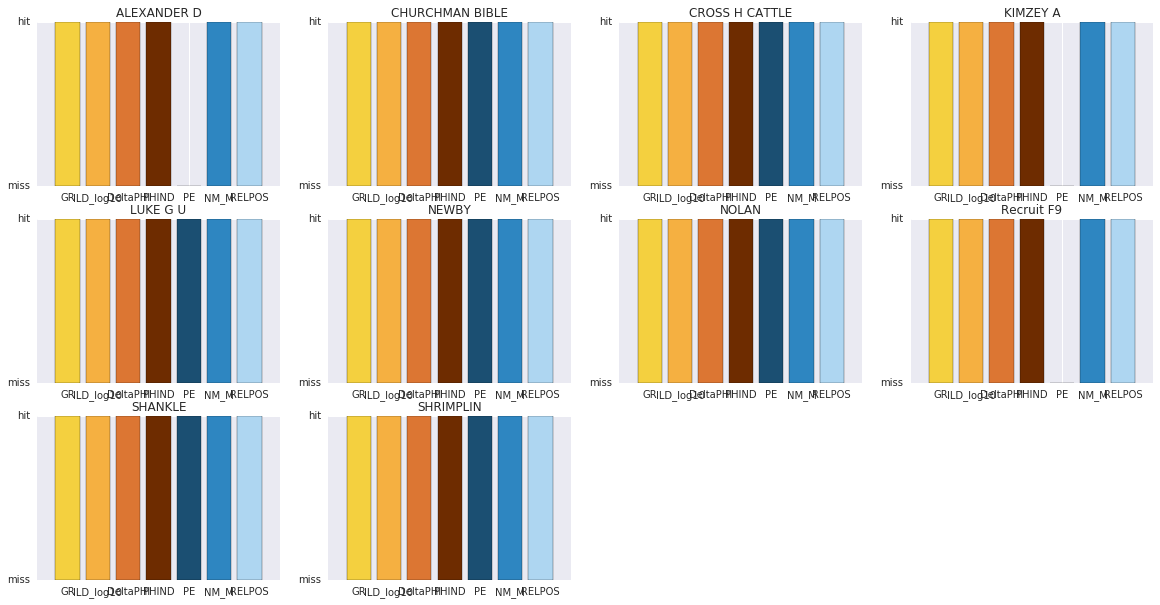

In [10]:
# Features per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.logical_not(np.any(np.isnan(X[well == w, :]), axis=0))
    plt.bar(np.arange(len(hist)), hist, color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(feature_names)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['miss', 'hit'])
    ax.set_title(w)

In [11]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
DataImpAll = data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))

In [12]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [13]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

# Feature gradient computation function
def augment_features_median(X, dist=3):
    #print(X)
    X_grad = None
    X_out = np.zeros((X.shape[0], 7))
    for i in range(X.shape[1]):
        X_out[:, i] = medfilt(X[:, i], dist)
    # Compensate for last missing value
    #X_out = np.array(X_out)
    #X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    print(X_out.shape)
    return X_out

In [14]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    print(X.shape)
    # Augment features
    X_aug = np.zeros((X.shape[0], 42))#X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        
        X_aug_cov = augment_features_median(X[w_idx, :])
        X_aug_grad_med = augment_features_median(X_aug_grad, dist=7)
        print(X_aug_win.shape, X_aug_grad.shape, X_aug_cov.shape)
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad, X_aug_cov, X_aug_grad_med), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [15]:
X_aug, padded_rows = augment_features(X, well, depth)

(4149, 7)
(466, 7)
(466, 7)
(466, 21) (466, 7) (466, 7)
(404, 7)
(404, 7)
(404, 21) (404, 7) (404, 7)
(501, 7)
(501, 7)
(501, 21) (501, 7) (501, 7)
(439, 7)
(439, 7)
(439, 21) (439, 7) (439, 7)
(461, 7)
(461, 7)
(461, 21) (461, 7) (461, 7)
(463, 7)
(463, 7)
(463, 21) (463, 7) (463, 7)
(415, 7)
(415, 7)
(415, 21) (415, 7) (415, 7)
(80, 7)
(80, 7)
(80, 21) (80, 7) (80, 7)
(449, 7)
(449, 7)
(449, 21) (449, 7) (449, 7)
(471, 7)
(471, 7)
(471, 21) (471, 7) (471, 7)


In [16]:
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (data['Well Name'][split['val']].unique()))

Split 0
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['ALEXANDER D' 'CHURCHMAN BIBLE']
Split 1
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN' 'Recruit F9' 'NEWBY'
 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'CROSS H CATTLE']
Split 2
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'KIMZEY A']
Split 3
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'NOLAN']
Split 4
    training:   ['SHRIMPLIN' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'SHANKLE']
Split 5
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE' 'CHURCHMAN BIBLE'

In [17]:
# Parameters search grid (uncomment parameters for full grid search... may take a lot of time)
md_grid = [3]
mcw_grid = [1]
gamma_grid = [0.3]  
ss_grid = [0.7] 
csb_grid = [0.8]
alpha_grid =[0.2]
lr_grid = [0.05]
ne_grid = [200]
param_grid = []
for N in md_grid:
    for M in mcw_grid:
        for S in gamma_grid:
            for L in ss_grid:
                for K in csb_grid:
                    for P in alpha_grid:
                        for R in lr_grid:
                            for E in ne_grid:
                                param_grid.append({'maxdepth':N, 
                                                   'minchildweight':M, 
                                                   'gamma':S, 
                                                   'subsample':L,
                                                   'colsamplebytree':K,
                                                   'alpha':P,
                                                   'learningrate':R,
                                                   'n_estimators':E})

In [18]:
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v,well_v):
    
    #Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)

    print("lel")
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [109]:
# For each set of parameters
score_param = []
for param in param_grid:
    
    clf = OneVsOneClassifier(XGBClassifier(
            learning_rate = param['learningrate'],
            n_estimators=param['n_estimators'],
            max_depth=param['maxdepth'],
            min_child_weight=param['minchildweight'],
            gamma = param['gamma'],
            subsample=param['subsample'],
            colsample_bytree=param['colsamplebytree'],
            reg_alpha = param['alpha'],
            nthread =1,
            seed = seed, silent=True
        ) , n_jobs=1)
    # For each data split
    score_split = []
    for split in split_list:
    
        # Remove padded rows
        split_train_no_pad = np.setdiff1d(split['train'], padded_rows)
        
        # Select training and validation data from current split
        X_tr = X_aug[split_train_no_pad, :]
        X_v = X_aug[split['val'], :]
        y_tr = y[split_train_no_pad]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v)
        
        score = f1_score(y_v, y_v_hat, average='micro')
        print("cur score", score)
        score_split.append(score)
        print("running mean", np.mean(score_split))
        
    # Average score for this param
    score_param.append(np.mean(score_split))
    print('F1 score = %.3f %s' % (score_param[-1], param))
          
# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))

lel
cur score 0.608045977011
running mean 0.608045977011
lel
cur score 0.501551189245
running mean 0.554798583128
lel
cur score 0.569060773481
running mean 0.559552646579
lel
cur score 0.594778660613
running mean 0.568359150088
lel
cur score 0.592349726776
running mean 0.573157265425
lel
cur score 0.500552486188
running mean 0.561056468886
lel
cur score 0.55753262159
running mean 0.560553062129
lel
cur score 0.615028901734
running mean 0.56736254208
lel
cur score 0.516724336794
running mean 0.561736074826
lel
cur score 0.567765567766
running mean 0.56233902412
lel
cur score 0.417355371901
running mean 0.5491586921
lel
cur score 0.586166471278
running mean 0.552242673698
lel
cur score 0.616
running mean 0.557147083413
lel
cur score 0.485106382979
running mean 0.552001319097
lel
cur score 0.505186721992
running mean 0.548880345956
lel
cur score 0.471600688468
running mean 0.544050367363
lel
cur score 0.497942386831
running mean 0.541338133214
lel
cur score 0.605555555556
running mean 0.5

In [110]:
print('Min Max', np.min(score_split), np.max(score_split))

Min Max 0.417355371901 0.616


In [19]:
for param in param_grid:
    
    clf = OneVsOneClassifier(XGBClassifier(
            learning_rate = param['learningrate'],
            n_estimators=param['n_estimators'],
            max_depth=param['maxdepth'],
            min_child_weight=param['minchildweight'],
            gamma = param['gamma'],
            subsample=param['subsample'],
            colsample_bytree=param['colsamplebytree'],
            reg_alpha = param['alpha'],
            nthread =4,
            seed = seed,
        ) , n_jobs=-1)

In [20]:
clf

OneVsOneClassifier(estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.3, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=4,
       objective='binary:logistic', reg_alpha=0.2, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.7),
          n_jobs=-1)

In [21]:
# Load data from file
test_data = pd.read_csv('../validation_data_nofacies.csv')

In [22]:
# Prepare training data
X_tr = X
y_tr = y

# Augment features
X_tr, padded_rows = augment_features(X_tr, well, depth)

# Removed padded rows
X_tr = np.delete(X_tr, padded_rows, axis=0)
y_tr = np.delete(y_tr, padded_rows, axis=0) 

(4149, 7)
(466, 7)
(466, 7)
(466, 21) (466, 7) (466, 7)
(404, 7)
(404, 7)
(404, 21) (404, 7) (404, 7)
(501, 7)
(501, 7)
(501, 21) (501, 7) (501, 7)
(439, 7)
(439, 7)
(439, 21) (439, 7) (439, 7)
(461, 7)
(461, 7)
(461, 21) (461, 7) (461, 7)
(463, 7)
(463, 7)
(463, 21) (463, 7) (463, 7)
(415, 7)
(415, 7)
(415, 21) (415, 7) (415, 7)
(80, 7)
(80, 7)
(80, 21) (80, 7) (80, 7)
(449, 7)
(449, 7)
(449, 21) (449, 7) (449, 7)
(471, 7)
(471, 7)
(471, 21) (471, 7) (471, 7)


In [23]:
# Prepare test data
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values

# Augment features
X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

(830, 7)
(356, 7)
(356, 7)
(356, 21) (356, 7) (356, 7)
(474, 7)
(474, 7)
(474, 21) (474, 7) (474, 7)


In [24]:
# Predict test labels
y_ts_hat = train_and_test(X_tr, y_tr, X_ts, well_ts)

lel


In [25]:
# Save predicted labels
test_data['Facies'] = y_ts_hat
test_data.to_csv('Prediction_houmath_edit.csv')

In [26]:
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
5,A1 SH,STUART,2810.5,73.955,0.667,6.900,12.250,3.086,1,0.889,3
6,A1 SH,STUART,2811.0,77.962,0.674,6.500,12.450,3.092,1,0.867,3
7,A1 SH,STUART,2811.5,83.894,0.667,6.300,12.650,3.123,1,0.844,3
8,A1 SH,STUART,2812.0,84.424,0.653,6.700,13.050,3.121,1,0.822,3
9,A1 SH,STUART,2812.5,83.160,0.642,7.300,12.950,3.127,1,0.800,3


In [27]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


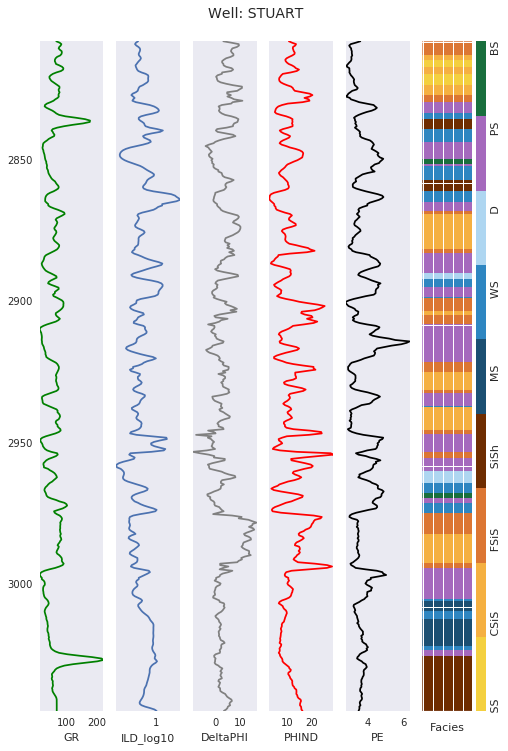

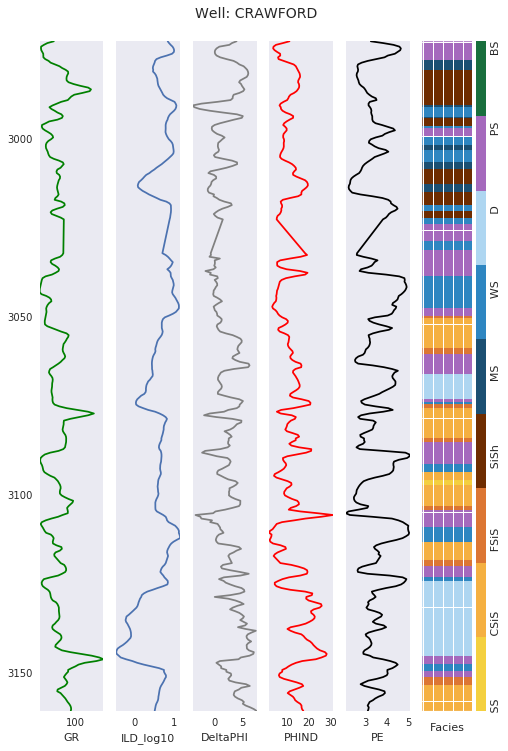

In [29]:
# Plot predicted labels
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
mpl.rcParams.update(inline_rc)